# L1 norm prior experiment

This code attempts to learn the 32D prior
$J(x) = ||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i)$- using Huber function 

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/L1_prior_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Section 3.1: Convex Prior J(x) = ||x||_1
    # S(x,t) is the Moreau Envelope of the L1 norm (Huber function).
    # Per component j: if |x_j| > t: |x_j| - t/2. If |x_j| <= t: x_j^2 / 2t
    
    abs_y = np.abs(y)
    # Mask for |x| <= t
    small_mask = abs_y <= t
    
    # Component-wise values
    comps = np.zeros_like(y)
    comps[small_mask] = (abs_y[small_mask]**2) / (2 * t)
    comps[~small_mask] = abs_y[~small_mask] - (t / 2.0)
    
    # Sum across dimensions (separable)
    return np.sum(comps, axis=1)


def prior_true(y):
    # J(x) = ||x||_1
    return np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1322.029541015625
iteration 0 loss 36.09401321411133


iteration 5000 loss 0.3954150974750519


iteration 10000 loss 0.2557339370250702


iteration 15000 loss 0.16670481860637665


iteration 20000 loss 0.11820800602436066


iteration 25000 loss 0.10075964778661728


iteration 30000 loss 0.08348379284143448


iteration 35000 loss 0.0658273920416832


iteration 40000 loss 0.05784955993294716


iteration 45000 loss 0.047772470861673355


iteration 50000 loss 0.05342152714729309


iteration 55000 loss 0.04323917254805565


iteration 60000 loss 0.032514799386262894


iteration 65000 loss 0.032165832817554474


iteration 70000 loss 28.917156219482422


iteration 75000 loss 0.02679605595767498


iteration 80000 loss 0.020978139713406563


iteration 85000 loss 0.022951295599341393


iteration 90000 loss 0.01819305680692196


iteration 95000 loss 0.01671917922794819


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.017536288127303123


iteration 105000 loss 0.013866209425032139


iteration 110000 loss 0.010565457865595818


iteration 115000 loss 0.008644795045256615


iteration 120000 loss 0.007186066824942827


iteration 125000 loss 0.005998033564537764


iteration 130000 loss 0.005248477682471275


iteration 135000 loss 0.004626187961548567


iteration 140000 loss 0.0040619857609272


iteration 145000 loss 0.0035463834647089243


iteration 150000 loss 0.003151708748191595


iteration 155000 loss 0.002798663452267647


iteration 160000 loss 0.0025181814562529325


iteration 165000 loss 0.0022465712390840054


iteration 170000 loss 0.0020347724203020334


iteration 175000 loss 0.001831098459661007


iteration 180000 loss 0.0016784041654318571


iteration 185000 loss 0.0015283977845683694


iteration 190000 loss 0.0014031423488631845


iteration 195000 loss 0.0012838012771680951


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0011619147844612598


iteration 205000 loss 0.0010719930287450552


iteration 210000 loss 0.0009730189922265708


iteration 215000 loss 0.0008761899662204087


iteration 220000 loss 0.0007824469939805567


iteration 225000 loss 0.0007151627214625478


iteration 230000 loss 0.0006462088786065578


iteration 235000 loss 0.0005819997750222683


iteration 240000 loss 0.0005337314214557409


iteration 245000 loss 0.0004885163507424295


iteration 250000 loss 0.0004397243319544941


iteration 255000 loss 0.00040589921991340816


iteration 260000 loss 0.00037483018240891397


iteration 265000 loss 0.0003458295832388103


iteration 270000 loss 0.000314286386128515


iteration 275000 loss 0.0002865433634724468


iteration 280000 loss 0.0002629751688800752


iteration 285000 loss 0.00024176765873562545


iteration 290000 loss 0.00022309779888018966


iteration 295000 loss 0.00020583653531502932


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.00019063246145378798


iteration 305000 loss 0.00018535525305196643


iteration 310000 loss 0.0001677339751040563


iteration 315000 loss 0.00015421515854541212


iteration 320000 loss 0.0001398109016008675


iteration 325000 loss 0.00012717144272755831


iteration 330000 loss 0.00011610703222686425


iteration 335000 loss 0.00010636734805302694


iteration 340000 loss 9.835997479967773e-05


iteration 345000 loss 9.015754767460749e-05


iteration 350000 loss 8.267137309303507e-05


iteration 355000 loss 7.66826924518682e-05


iteration 360000 loss 6.997460877755657e-05


iteration 365000 loss 6.426014442695305e-05


iteration 370000 loss 5.963224612060003e-05


iteration 375000 loss 5.50189615751151e-05


iteration 380000 loss 6.091320392442867e-05


iteration 385000 loss 4.708694541477598e-05


iteration 390000 loss 4.375020580482669e-05


iteration 395000 loss 4.0194041503127664e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 3.695475243148394e-05


iteration 405000 loss 3.6626435758080333e-05


iteration 410000 loss 3.335166911710985e-05


iteration 415000 loss 2.9185441235313192e-05


iteration 420000 loss 2.5470315449638292e-05


iteration 425000 loss 2.2159494619700126e-05


iteration 430000 loss 1.9220286048948765e-05


iteration 435000 loss 1.662476461206097e-05


iteration 440000 loss 1.4342125723487698e-05


iteration 445000 loss 1.2355329090496525e-05


iteration 450000 loss 1.0639226275088731e-05


iteration 455000 loss 9.167869393422734e-06


iteration 460000 loss 7.906223800091539e-06


iteration 465000 loss 6.823776402598014e-06


iteration 470000 loss 5.895657523069531e-06


iteration 475000 loss 5.099087957205484e-06


iteration 480000 loss 4.415885086928029e-06


iteration 485000 loss 3.833133177977288e-06


iteration 490000 loss 3.3429446375521366e-06


iteration 495000 loss 2.9609989269374637e-06


L2 loss -- Plot

loss -75.07708740234375


loss -268.7433166503906


loss -400.0598449707031


loss -499.0694580078125


loss -584.5249633789062


loss -664.2545166015625


loss -739.3270263671875


loss -809.27392578125


loss -873.0366821289062


loss -929.565673828125


loss -978.2374267578125


loss -1018.7135009765625


loss -1050.9736328125


loss -1075.6298828125


loss -1093.7509765625


loss -1106.511474609375


loss -1115.02587890625


loss -1120.3193359375


loss -1123.326416015625


loss -1124.8548583984375


loss -1125.5318603515625


loss -1125.7833251953125


loss -1125.857666015625


loss -1125.8739013671875


loss -1125.8763427734375


loss -1125.8765869140625


loss -1125.8765869140625


loss -1125.8765869140625


loss -1125.8765869140625


loss -1125.8765869140625


loss -1125.8765869140625


loss -1125.8765869140625


loss -1125.8765869140625


loss -1125.8765869140625


loss -1125.8765869140625


loss -1125.8765869140625


loss -1125.8765869140625


loss -1125.8765869140625


loss -1125.8765869140625


loss -1125.8765869140625


final mse:  4.1322939514643053e-10
max, min: 8.440945 -8.453383
loss -75.07708740234375


loss -269.78125


loss -400.20867919921875


loss -498.1090087890625


loss -582.1097412109375


loss -659.0556640625


loss -729.934814453125


loss -794.1053466796875


loss -850.7317504882812


loss -899.5468139648438


loss -940.848876953125


loss -975.1314697265625


loss -1002.8358154296875


loss -1024.3642578125


loss -1040.265380859375


loss -1051.3123779296875


loss -1058.42919921875


loss -1062.6136474609375


loss -1064.8232421875


loss -1065.846435546875


loss -1066.246337890625


loss -1066.371337890625


loss -1066.400390625


loss -1066.405029296875


loss -1066.4053955078125


loss -1066.405517578125


loss -1066.405517578125


loss -1066.405517578125


loss -1066.405517578125


loss -1066.4053955078125


loss -1066.405517578125


loss -1066.4053955078125


loss -1066.405517578125


loss -1066.405517578125


loss -1066.405517578125


loss -1066.405517578125


loss -1066.405517578125


loss -1066.4053955078125


loss -1066.405517578125


loss -1066.405517578125


final mse:  3.2176053488264245e-10
max, min: 8.169395 -8.178718


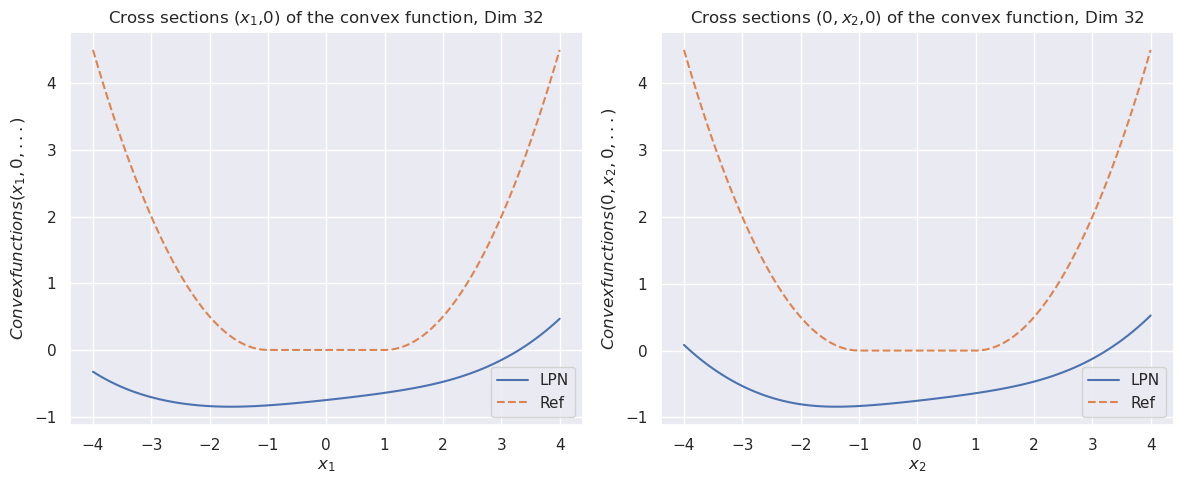

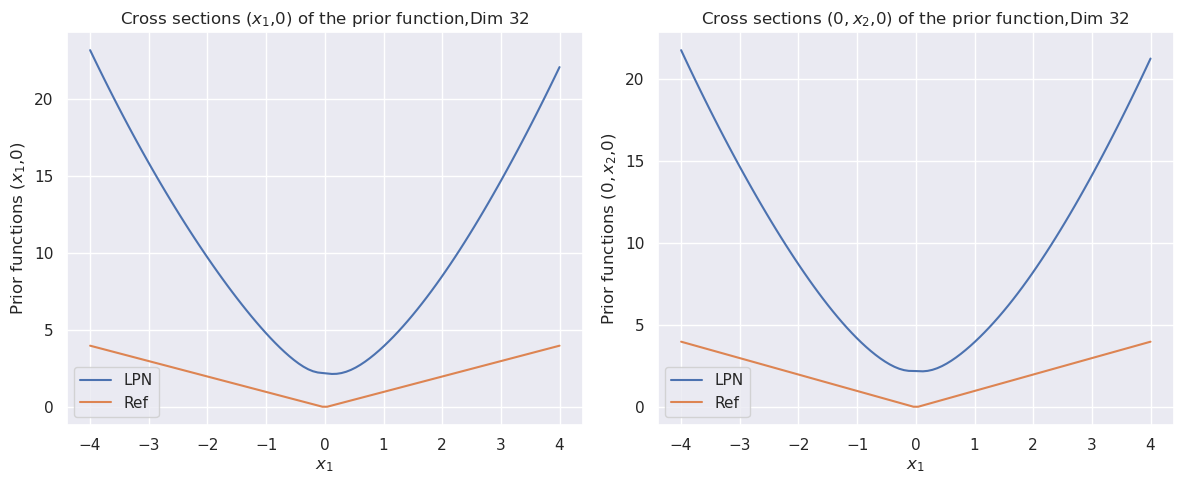

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 3376.170654296875
iteration 0 loss 1453.1357421875


iteration 5000 loss 0.3965616226196289


iteration 10000 loss 0.20303472876548767


iteration 15000 loss 0.21599498391151428


iteration 20000 loss 0.10363756120204926


iteration 25000 loss 0.08442879468202591


iteration 30000 loss 0.07246650010347366


iteration 35000 loss 0.06025607883930206


iteration 40000 loss 0.06654609739780426


iteration 45000 loss 0.04800954461097717


iteration 50000 loss 0.04600628465414047


iteration 55000 loss 0.04760250821709633


iteration 60000 loss 0.03388337418437004


iteration 65000 loss 0.03472025692462921


iteration 70000 loss 0.029080351814627647


iteration 75000 loss 0.025122899562120438


iteration 80000 loss 0.026681261137127876


iteration 85000 loss 0.024916505441069603


iteration 90000 loss 0.02209918014705181


iteration 95000 loss 0.018474556505680084


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.017528332769870758


iteration 105000 loss 0.015311349183321


iteration 110000 loss 0.01280265487730503


iteration 115000 loss 0.011171958409249783


iteration 120000 loss 0.009542599320411682


iteration 125000 loss 0.008465803228318691


iteration 130000 loss 0.011960375122725964


iteration 135000 loss 0.006570030935108662


iteration 140000 loss 0.005750532262027264


iteration 145000 loss 0.005154478829354048


iteration 150000 loss 0.004591511562466621


iteration 155000 loss 0.004154473543167114


iteration 160000 loss 0.003691013203933835


iteration 165000 loss 0.003330462146550417


iteration 170000 loss 0.003014208050444722


iteration 175000 loss 0.0027472509536892176


iteration 180000 loss 0.0024998027365654707


iteration 185000 loss 0.0022563342936336994


iteration 190000 loss 0.002050823997706175


iteration 195000 loss 0.0018657565815374255


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0017075145151466131


iteration 205000 loss 0.0016625170828774571


iteration 210000 loss 0.0015180526534095407


iteration 215000 loss 0.0013869550311937928


iteration 220000 loss 0.0012773240450769663


iteration 225000 loss 0.0011584138264879584


iteration 230000 loss 0.0010718060657382011


iteration 235000 loss 0.0009706891723908484


iteration 240000 loss 0.0008872768376022577


iteration 245000 loss 0.0008131219656206667


iteration 250000 loss 0.0007461645873263478


iteration 255000 loss 0.000690036395099014


iteration 260000 loss 0.0006341224652715027


iteration 265000 loss 0.0005862829275429249


iteration 270000 loss 0.0005434596678242087


iteration 275000 loss 0.0004979021032340825


iteration 280000 loss 0.0004570968449115753


iteration 285000 loss 0.00042289221892133355


iteration 290000 loss 0.00038945316919125617


iteration 295000 loss 0.00036143482429906726


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.00033446939778514206


iteration 305000 loss 0.0003165107627864927


iteration 310000 loss 0.00029151380294933915


iteration 315000 loss 0.00027011020574718714


iteration 320000 loss 0.0002478967944625765


iteration 325000 loss 0.00022703369904775172


iteration 330000 loss 0.0002086351887555793


iteration 335000 loss 0.0001939277135534212


iteration 340000 loss 0.00017909062444232404


iteration 345000 loss 0.00016673648497089744


iteration 350000 loss 0.00015432178042829037


iteration 355000 loss 0.00014166583423502743


iteration 360000 loss 0.00013032043352723122


iteration 365000 loss 0.00012238335330039263


iteration 370000 loss 0.00011254912533331662


iteration 375000 loss 0.00010483449295861647


iteration 380000 loss 9.709797450341284e-05


iteration 385000 loss 8.967913163360208e-05


iteration 390000 loss 8.388033893425018e-05


iteration 395000 loss 7.767284841975197e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 7.198879757197574e-05


iteration 405000 loss 6.883121386636049e-05


iteration 410000 loss 6.214431050466374e-05


iteration 415000 loss 5.6151984608732164e-05


iteration 420000 loss 5.0716982514131814e-05


iteration 425000 loss 4.577770596370101e-05


iteration 430000 loss 4.128526779823005e-05


iteration 435000 loss 3.7197631172602996e-05


iteration 440000 loss 3.347725578350946e-05


iteration 445000 loss 3.009396095876582e-05


iteration 450000 loss 2.7023439542972483e-05


iteration 455000 loss 2.423874320811592e-05


iteration 460000 loss 2.172093627450522e-05


iteration 465000 loss 1.9449957108008675e-05


iteration 470000 loss 1.7399011994712055e-05


iteration 475000 loss 1.5552290278719738e-05


iteration 480000 loss 1.3890627087675966e-05


iteration 485000 loss 1.2395644262142014e-05


iteration 490000 loss 1.1054328751924913e-05


iteration 495000 loss 9.853222763922531e-06


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


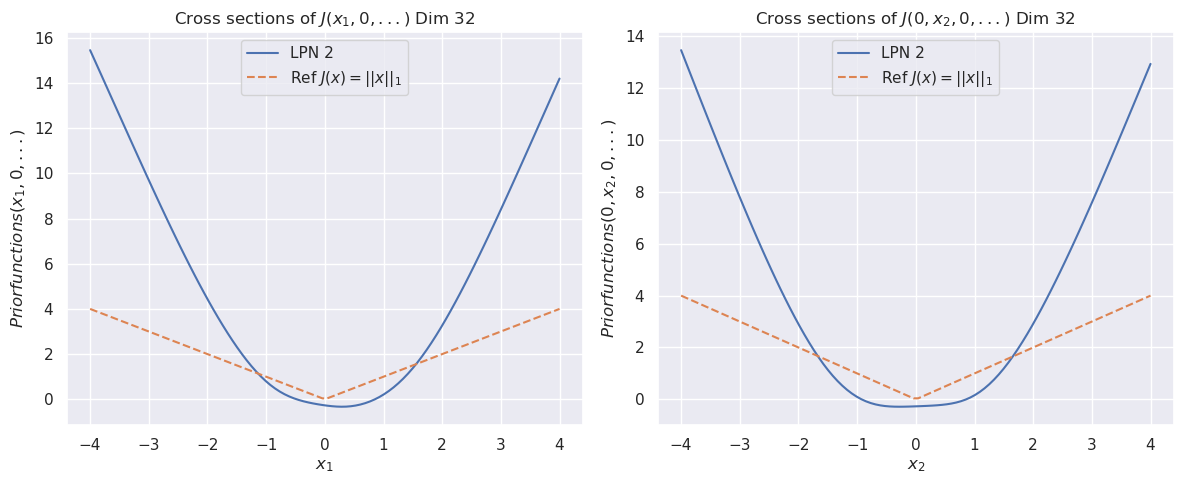

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)